## **Setup + Introduction**

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as lyrs, optimizers as opts, activations as acts, losses as ls

import matplotlib.pyplot as plt


## **Training, evaluation, and inference**

>> **The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build `graphs of layers`.**

In [2]:
'''
    Creating a Linear totplogy using functional layer!!
    Topology:
        Inputs([784]) => Dense(units= 64, 'relu') => Dense(units= 32, 'relu') => Dense(units= 10, 'softmax')
'''

inp = tfk.Input(shape=[784], name='Input_Layer')
d1 = lyrs.Dense(128, 'relu', name= 'Dense_1')(inp)
d2 = lyrs.Dense(64, 'relu', name= 'Dense_2')(d1)
out = lyrs.Dense(10, 'softmax', name= 'OutputLayer')(d2)


model = tfk.Model(inputs= inp, outputs= out, name='Classification_Model')
model.summary()


Model: "Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Dense_1 (Dense)             (None, 128)               100480    
                                                                 
 Dense_2 (Dense)             (None, 64)                8256      
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


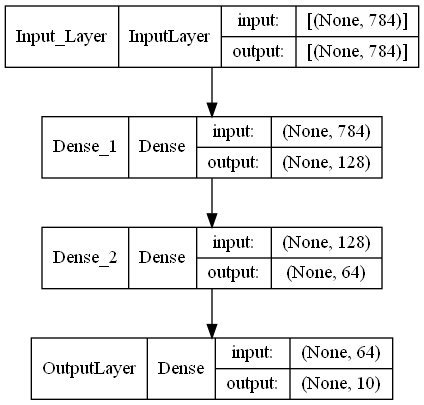

In [5]:
tfk.utils.plot_model(model, to_file='model.png', show_shapes= True)

In [4]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

'''
    1. Preparing data
    2. Building the Model
    3. Train and evaluate 
'''

dataset = tfk.datasets.mnist
(tr_data, tr_lbls), (ts_data, ts_lbls) = dataset.load_data()

# We Flatten the incoming tensor, to convert its dimensions from [28, 28] to (28 x 28)
# We use astype to change type of data

print(tr_data.shape)
print(tr_data.dtype)

tr_data = lyrs.Flatten()(tr_data).astype('float32') / 255.0
ts_data = ts_data.reshape(-1,784).astype('float32') / 255.0

print(ts_data.shape)
print(tr_data.dtype)


(60000, 28, 28)
uint8
(10000, 784)
<dtype: 'float32'>


In [5]:
model.compile(
    optimizer= opts.Adam(learning_rate= 0.005),
    loss= ls.SparseCategoricalCrossentropy(),
    metrics= ['accuracy']
)

his = model.fit(
    tr_data,
    tr_lbls,
    validation_split=0.25,
    batch_size=64,
    epochs=20,
    verbose=1
)

Epoch 1/20
704/704 [==============================] - 4s 5ms/step - loss: 0.2483 - accuracy: 0.9247 - val_loss: 0.1587 - val_accuracy: 0.9527
Epoch 2/20
704/704 [==============================] - 3s 4ms/step - loss: 0.1200 - accuracy: 0.9635 - val_loss: 0.1770 - val_accuracy: 0.9499
Epoch 3/20
704/704 [==============================] - 3s 4ms/step - loss: 0.0913 - accuracy: 0.9718 - val_loss: 0.1393 - val_accuracy: 0.9593
Epoch 4/20
704/704 [==============================] - 3s 4ms/step - loss: 0.0794 - accuracy: 0.9752 - val_loss: 0.1355 - val_accuracy: 0.9639
Epoch 5/20
704/704 [==============================] - 3s 4ms/step - loss: 0.0673 - accuracy: 0.9800 - val_loss: 0.1462 - val_accuracy: 0.9633
Epoch 6/20
704/704 [==============================] - 3s 4ms/step - loss: 0.0595 - accuracy: 0.9815 - val_loss: 0.1480 - val_accuracy: 0.9653
Epoch 7/20
704/704 [==============================] - 3s 4ms/step - loss: 0.0519 - accuracy: 0.9839 - val_loss: 0.1458 - val_accuracy: 0.9663
Epoch 

In [6]:


def plot_history(history, metric):
    r = len(history[metric])
    plt.plot(history[metric], label='Training')
    plt.plot(history['val_'+ metric], label='Validation')
    plt.title(metric)
    
    if metric == 'loss':
        plt.ylim([0, 1])
    else:
        plt.ylim([0.9, 1.0])
    plt.legend()
        

history = his.history
print(history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


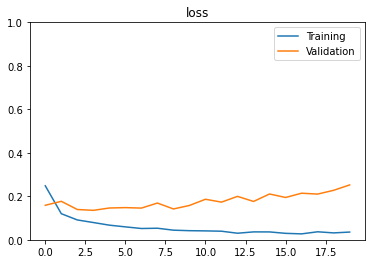

In [7]:

plot_history(history, 'loss')


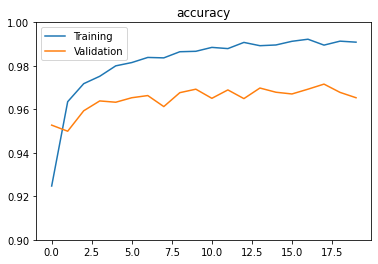

In [8]:

plot_history(history, 'accuracy')


## **Save and serialize**
**The standard way to save a functional model is to call model.save() to save the entire model as a single file. You can later recreate the same model from this file, even if the code that built the model is no longer available.**

> **`The Saved Model includes:`**
1. **Model Architecture**
2. **Model Weights**
3. **Model training config**
4. **Optimizer and its state**

In [10]:
# save Model
model.save('SavedModel')

# delete existing model
# !! del model !!

# Reloading Model
model_loaded = tfk.models.load_model('SavedModel')
pred = model_loaded(ts_data[:10])


tf.nn.softmax(pred)
for i in pred:
    print(np.argmax(i))
    

INFO:tensorflow:Assets written to: SavedModel\assets


INFO:tensorflow:Assets written to: SavedModel\assets


7
2
1
0
4
1
4
9
6
9


## **Reusing graph of layers to define multiple**

In [15]:
# First we will create an Encoder by stacking layers.
# Then, we will reuse the existing layers graph to instantiate new model that decodes the encoder-output.

encoder_inp = lyrs.Input((28, 28, 1), name='InputLayer')
x = lyrs.Conv2D(128, 3, activation='relu')(encoder_inp)
x = lyrs.Conv2D(128, 3, activation='relu')(x)
x = lyrs.MaxPooling2D(3)(x)
x = lyrs.Conv2D(64, 3, activation='relu')(x)
x = lyrs.Conv2D(64, 3, activation='relu')(x)
encoder_out = lyrs.GlobalMaxPooling2D()(x)

model_encoder = tfk.Model(encoder_inp, encoder_out, name='Encoder')
model_encoder.summary()


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 64)          73792     
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 64)          36928     
                                                           

In [17]:
# Now creating the decoder!!
autoencoder_inp = lyrs.Reshape((8, 8, 1))(encoder_out)
x = lyrs.Conv2DTranspose(128, 3, activation='relu')(autoencoder_inp)
x = lyrs.Conv2DTranspose(64, 3, activation='relu')(x)
x = lyrs.UpSampling2D(3)(x)
x = lyrs.Conv2DTranspose(32, 3, activation='relu')(x)
autoencoder_out = lyrs.Conv2DTranspose(1, 3, activation='relu')(x)

model_autoencoder = tfk.Model(encoder_inp, autoencoder_out, name='autoencoder')
model_autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 64)          73792     
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 64)          36928     
                                                       

## **Callable Models, just like layers**

> **Treating `NeuralNet-Models` like `KerasLayers` allows us to design modular-Models, which can take in any specific input and produce an output. Models can also be combined||stacked like layers to form pipelines(Model architecture)**

In [29]:
"""
    In this part, we are going to form a autoencoder by 
    first creating seperate encoders and decoders, then chaining them together 
    to form autoencoder architecture
"""

Encoder_Inp = tfk.Input(shape=(150, 150, 1), name='Encoded_Image')
lyr = lyrs.Conv2D(128, 3, activation='relu')(Encoder_Inp)
lyr = lyrs.Conv2D(128, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(128, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(3)(lyr)

lyr = lyrs.Conv2D(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(32, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(3)(lyr)

lyr = lyrs.Conv2D(32, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(32, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(16, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(2)(lyr)
Encoder_Out = lyrs.GlobalMaxPooling2D()(lyr)

ModelEncoder = tfk.Model(Encoder_Inp, Encoder_Out, name='Encoder')
ModelEncoder.summary()


Decoder_Inp = tfk.Input(shape=(16, ), name='Encoded_Image')
lyr = lyrs.Reshape((4, 4, 1))(Decoder_Inp)
lyr = lyrs.UpSampling2D(3)(lyr)

lyr = lyrs.Conv2DTranspose(32, 2, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(32, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.UpSampling2D(2)(lyr)

lyr = lyrs.Conv2DTranspose(128, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(128, 3, activation='relu')(lyr)
lyr = lyrs.UpSampling2D(3)(lyr)

lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
output = lyrs.Conv2DTranspose(1, 3, activation='relu')(lyr)

ModelDecoder = tfk.Model(Decoder_Inp, output, name='Decoder')
ModelDecoder.summary()

autoenc_inp = tfk.Input((150, 150, 1), name='AutoEncoder_Input')

encoded_image = ModelEncoder(autoenc_inp)
decoded_image = ModelDecoder(encoded_image)

autoencoder = tfk.Model(autoenc_inp, decoded_image, name='AutoEncoder')
autoencoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoded_Image (InputLayer)  [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_75 (Conv2D)          (None, 148, 148, 128)     1280      
                                                                 
 conv2d_76 (Conv2D)          (None, 146, 146, 128)     147584    
                                                                 
 conv2d_77 (Conv2D)          (None, 144, 144, 128)     147584    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 48, 48, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 46, 46, 64)        73792     
                                                           

In [ ]:
encoder_input = tfk.Input(shape=(28, 28, 1), name="original_img")
x = lyrs.Conv2D(16, 3, activation="relu")(encoder_input)
x = lyrs.Conv2D(32, 3, activation="relu")(x)
x = lyrs.MaxPooling2D(3)(x)
x = lyrs.Conv2D(32, 3, activation="relu")(x)
x = lyrs.Conv2D(16, 3, activation="relu")(x)
encoder_output = lyrs.GlobalMaxPooling2D()(x)

encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = tfk.Input(shape=(16,), name="encoded_img")
x = lyrs.Reshape((4, 4, 1))(decoder_input)
x = lyrs.Conv2DTranspose(16, 3, activation="relu")(x)
x = lyrs.Conv2DTranspose(32, 3, activation="relu")(x)
x = lyrs.UpSampling2D(3)(x)
x = lyrs.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = lyrs.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = tfk.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = tfk.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = tfk.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()


> **As you can see, the model can be nested: a model can contain sub-models (since a model is just like a layer). A common use case for model nesting is `ensembling`. For example, here's how to ensemble a set of models into a single model that `averages their predictions`**

In [52]:
def get_Model(name):
    inp = tfk.Input(shape=(256, ))
    lyr = lyrs.Dense(128, activation=acts.relu)(inp)
    lyr = lyrs.Dense(64, activation=acts.relu)(lyr)
    out = lyrs.Dense(16, activation=acts.relu)(lyr)
    return tfk.Model(inp, out, name=name)

# Creating 3 Samilar Models...
m1 = get_Model('Model_1')
m2 = get_Model('Model_2')
m3 = get_Model('Model_3')

# Calling the models on an input-layer...
inp = tfk.Input(shape=(256, ))
y1, y2, y3 = m1(inp), m2(inp), m3(inp)

# Averaging the models_outputs using average layer...
out = lyrs.average([y1, y2, y3])

# Ensemble learning
EnsmebleModel = tfk.Model(inputs= inp, outputs= out, name='Ensemble_Model')
EnsmebleModel.summary()


Model: "Ensemble_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 Model_1 (Functional)           (None, 16)           42192       ['input_66[0][0]']               
                                                                                                  
 Model_2 (Functional)           (None, 16)           42192       ['input_66[0][0]']               
                                                                                                  
 Model_3 (Functional)           (None, 16)           42192       ['input_66[0][0]']               
                                                                                     

Ellipsis

## **Manipulate complex graph topologies**

> #### **Multi Inputs / Outputs**

**Printing Movie Tickets for customers**

**`Inputs:`**
1. The Title of the ticket
2. The text body of the ticket(categorical input)
3. Tags added by the user

**`Outputs:`**
1. Priority between 0-1
2. The department that should handle the ticket(softmax over the set of departments)


In [73]:
num_tags = 12 # Number of unique issue-tags.
num_words = 10000 # Size of vocabulary when preprocessing the text.
num_depts = 4 # Number of departments for predictions.

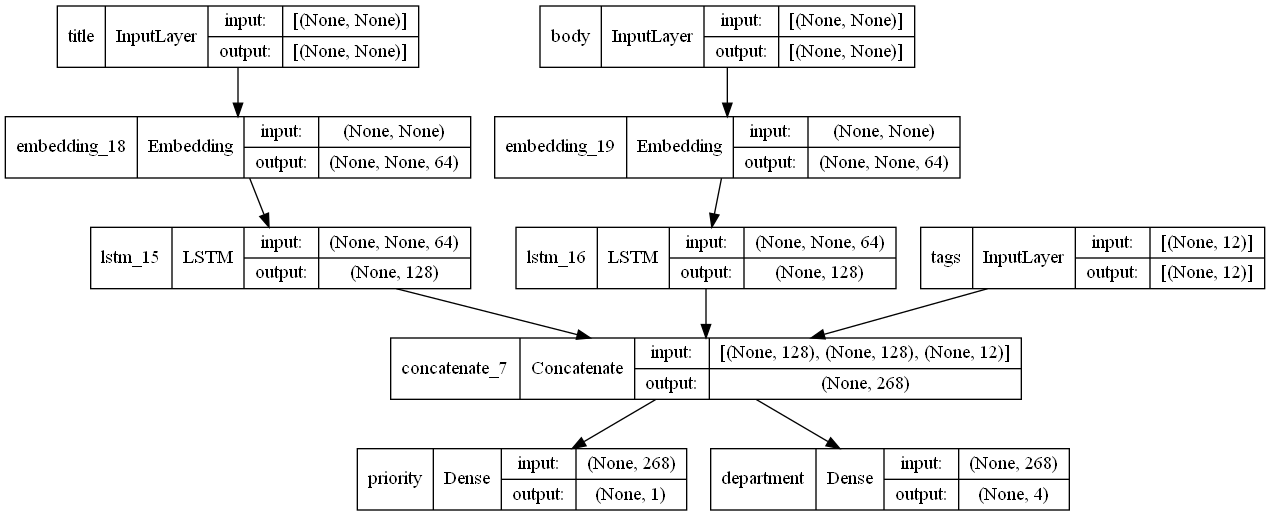

In [85]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = tfk.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = tfk.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = tfk.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = lyrs.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = lyrs.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = lyrs.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = lyrs.LSTM(128)(body_features)

# Merge all available features into a single large vector via concatenation
x = lyrs.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = lyrs.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = lyrs.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = tfk.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

tfk.utils.plot_model(model, 'Model_TicketClassifier.png', show_shapes=True)

In [86]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(1e-3),
    loss=[
        tfk.losses.BinaryCrossentropy(from_logits=True),
        tfk.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)


# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=20,
    batch_size=32,
)


Epoch 1/20


> #### **Mini Resnet**

## **Shared Layers**

## **Extract and reuse Nodes in graph of layers**

## **Extend the Func-API using custom-layers**

## **Practical Use**

> #### **Strengths**

> #### **Weaknesses**

## **Mix n Match API styles**